In [15]:
from positionEstimatorTraining import positionEstimatorTraining
from positionEstimator import positionEstimator

Testing the continuous position estimator...
(1, 8)
(99, 8)
Decoding block 1 out of 1
(98, 656)
(98, 627)
(98, 613)
(98, 671)
(98, 743)
(98, 628)
(98, 616)
(98, 607)


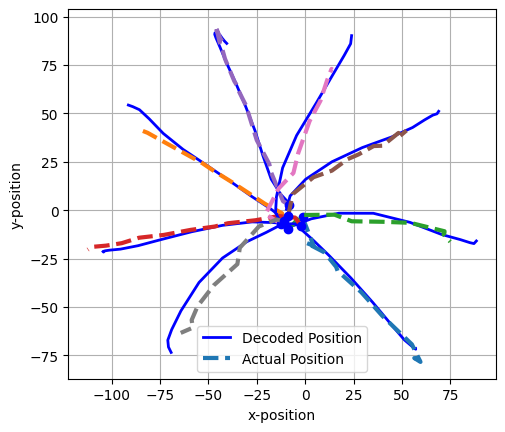

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy.io import loadmat

# Load the .mat file
mat_data = loadmat('monkeydata_training.mat')

# Extract the 'trial' data
trial_data = mat_data['trial']

# Convert to a Python dictionary
trial_dict = {'trial': trial_data}

print('Testing the continuous position estimator...')

meanSqError = 0
n_predictions = 0

fig, ax = plt.subplots()
ax.set_aspect('equal')
ax.grid(True)
count = 1


# Split the data into training and test sets
trainingData = trial_dict['trial'][:99]
testData = trial_dict['trial'][99:100]

# Train Model
model_parameters = positionEstimatorTraining(trainingData)
print(testData.shape)
print(trainingData.shape)

Angles = []

for tr in range(testData.shape[0]):
    print(f'Decoding block {tr + 1} out of {testData.shape[0]}')

    for direc in np.random.permutation(8):
        decodedHandPos = []
        print(testData[tr][direc]['spikes'].shape)
        times = np.arange(320, testData[tr][direc]['spikes'].shape[1] - 100, 20)
        model_parameters[0]['direction'] = direc

        for t in times:
            past_current_trial = {
                'trialId': testData[tr][direc]['trialId'],
                'spikes': testData[tr][direc]['spikes'][:, :t],
                'decodedHandPos': decodedHandPos,
                'startHandPos': testData[tr][direc]['handPos'][:2, 0]
            }

            # Decode Model
            if len(positionEstimator(past_current_trial, model_parameters)) == 3:
                decodedPosX, decodedPosY, newParameters = positionEstimator(past_current_trial, model_parameters)
                modelParameters = newParameters
            else:
                decodedPosX, decodedPosY = positionEstimator(past_current_trial, model_parameters)
                
            decodedPos = np.array([decodedPosX, decodedPosY])

            decodedHandPos.append(decodedPos)

            meanSqError += np.linalg.norm(testData[tr][direc]['handPos'][:2, t] - decodedPos)**2

        n_predictions += len(times)

        ax.plot(testData[tr][direc]['handPos'][0, times], testData[tr][direc]['handPos'][1, times], 'b', linewidth=2)
        ax.plot(np.array(decodedHandPos)[:, 0], np.array(decodedHandPos)[:, 1], '--', linewidth=3)
        ax.plot(decodedHandPos[0][0], decodedHandPos[0][1], 'bo')

        ax.set_xlabel('x-position')
        ax.set_ylabel('y-position')

        Angles.append([direc, tr, testData[tr][direc]['trialId'], modelParameters[0]['direction'],
                            testData[tr][direc]['spikes'].shape[1]])
        count += 1

plt.legend(['Decoded Position', 'Actual Position'])

# Check accuracy
RMSE = np.sqrt(meanSqError / n_predictions)

#aa = np.zeros(Angles.shape[1])
#for i in range(Angles.shape[1]):
#    aa[i] = (Angles[0, i] - Angles[3, i]) == 0

#accuracy = np.sum(aa) / Angles.shape[1]

# Set x-axis tick labels
# ax.set_xticklabels(['Step 1', 'Step 2', 'strawberries', 'pears'])

plt.show()

 